In [5]:
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from bbox import * 
from pytz import timezone
import os
from shapely.wkt import loads
import numpy as np
import xarray as xr
import gc

In [2]:
#################################################
##               Full Mobile Air               ##
#################################################

# files = os.listdir('../../data/mobile_air_data/')

# full_df = pd.DataFrame()

# for file in files:
    
#     df = pd.read_csv(f'../../data/mobile_air_data/{file}')
#     print(file)
#     df=df[['geometry', 'pass_start_time', 'pass_end_time',
#            'no2 ppb']]
#     df = df[~df['no2 ppb'].isna()]
#     # Convert start_time and end_time to datetime
#     df["pass_start_time"] = pd.to_datetime(df["pass_start_time"])
#     df["pass_end_time"] = pd.to_datetime(df["pass_end_time"])
#     # Calculate pass_time (duration in timedelta) Mean pass time of 5 seconds, max of 1 min 12 seconds
#     df["pass_time"] = df["pass_end_time"] - df["pass_start_time"]
#     # Convert start_time to Central Time and round down to the beginning of the hour
#     central = timezone("US/Central")
#     df1 = df[['geometry', 'pass_start_time', 'pass_time', 'no2 ppb']]
#     df2 = df[['geometry', 'pass_end_time', 'pass_time', 'no2 ppb']]
#     df1["time"] = df["pass_start_time"].dt.tz_convert(central).dt.floor("h")
#     df1["time"] = df1["time"].dt.tz_localize(None)
#     df2["time"] = df2["pass_end_time"].dt.tz_convert(central).dt.floor("h")
#     df2["time"] = df2["time"].dt.tz_localize(None)
#     df = pd.merge(df1, df2, on=['geometry', 'time', 'no2 ppb'])
#     df = df[['geometry', 'time', 'no2 ppb', 'pass_start_time', 'pass_end_time']]
#     del df1
#     del df2
    
#     full_df = pd.concat([full_df, df], axis=0)
#     full_df.to_csv('../../data/mobile_air_data/combined_data_no2.csv')

In [6]:
full_df=pd.read_csv('../../data/mobile_air_data/combined_data_no2.csv', index_col=0)

#################################################
##              Create Pass-> Grid Key         ##
#################################################

# All passes-- duplicated if cross over multiple hours
all_passes=full_df[['geometry']]
all_passes.drop_duplicates(inplace=True)
all_passes["geometry_join"] = all_passes["geometry"].apply(loads)
all_passes = gpd.GeoDataFrame(all_passes, geometry="geometry_join", crs="EPSG:4326")


# Create gridded GDF
res = 0.01 
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x


# Final join-- counts line segments if intersect with multiple 
key = gpd.sjoin(grid_gdf, all_passes, how="inner", predicate="intersects")
key["geometry_right"] = key["geometry_right"].apply(loads)
# For each intersected line and grid cell, calculate the length of the intersection
key['intersection_length'] = key.apply(lambda row: row.geometry.intersection(row.geometry_right).length, axis=1)
key = pd.DataFrame(key)
key=key[['geometry', 'geometry_right', 'lat', 'lon', 'intersection_length']]
key = key.rename(columns = {'geometry_right':'pass_geo'})

# Merge with Full DF
full_df = full_df.rename(columns = {'geometry':'pass_geo'})
full_df["pass_geo"] = full_df["pass_geo"].apply(loads)
# key["pass_geo"] = key["pass_geo"].apply(loads)
full_df['pass_geo']=full_df['pass_geo'].astype(str)
key['pass_geo']=key['pass_geo'].astype(str)
merged_df= pd.merge(full_df, key, on='pass_geo')
merged_df=merged_df[['geometry', 'lat', 'lon', 'time','no2 ppb','intersection_length']]
merged_df = merged_df.rename(columns = {'no2 ppb':'no2'})

# Select times in TEMPO files
no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")
mobile_time_list = np.array(merged_df['time'].unique(), dtype="datetime64[ns]")

seta = set(mobile_time_list)
setb = set(time_list)
union_set = seta & setb
full_time_list = list(union_set)

# Convert to pandas datetime objects
pd_datetime_list = list(pd.to_datetime(full_time_list))
merged_df['time']=pd.to_datetime(merged_df['time'])
merged_df=merged_df[merged_df['time'].isin(pd_datetime_list)]

# Group by 'geometry', 'lat', 'lon', and 'time'
grouped = merged_df.groupby(['geometry', 'lat', 'lon', 'time'])
# Calculate the weighted average of 'no2' using 'intersection_length' as the weight
grouped = grouped.apply(lambda x: (x['no2'] * x['intersection_length']).sum() / x['intersection_length'].sum())
# Reset the index to get a flat DataFrame
final_df = grouped.reset_index(name='weighted_no2')

del merged_df
del full_df
del key
del all_passes
del grouped
del seta
del setb
del union_set
gc.collect()

In [11]:
final_df.to_csv('../../data/mobile_air_data/final_mobile_withgrid.csv')

In [12]:
# # Initialize an empty list to hold xarrays
# xarrays_list = []

# for i, time in enumerate(pd_datetime_list):
#     print(i)
#     no2_df = final_df[final_df['time']==time]
#     time_df = pd.merge(grid_gdf, no2_df, on=['geometry', 'lat', 'lon'], how='left')
#     time_df['time'] = time_df['time'].fillna(time)
    
#     # Pivot the data into a 2D array
#     time_df_pivot = time_df.pivot(index="lat", columns="lon", values="weighted_no2")

#     # Convert to xarray
#     da = xr.DataArray(
#         time_df_pivot.values,
#         coords={
#             "lat": time_df_pivot.index.values,
#             "lon": time_df_pivot.columns.values,
#         },
#         dims=["lat", "lon"],
#         name="no2"
#     )
#     ds_expanded = da.expand_dims({'time': [time]})
#     # Append the expanded xarray to the list
#     xarrays_list.append(ds_expanded)

# # Concatenate all the xarrays in the list along the 'time' dimension
# final_ds = xr.concat(xarrays_list, dim='time')

In [13]:
# final_ds.to_netcdf(f'../../data/mobile_air_data/full_gridded_mobile.nc', engine='h5netcdf')

AttributeError: Line2D.set() got an unexpected keyword argument 'cmap'

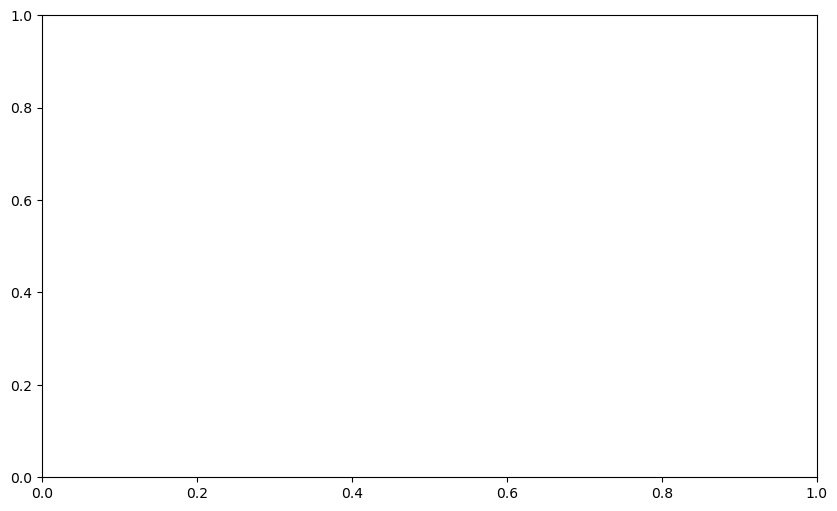

In [14]:
import matplotlib.pyplot as plt
# # # Define your latitude and longitude bounds
# # lat_min, lat_max = 28.6, 33.4  # Example latitude range
# # lon_min, lon_max = -98.9, -88.3  # Example longitude range

# # Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 1  # Change this to select a different hour if desired
# # temperature_data = nldas_month['temperature'].isel(time=hour_index)
# temperature_data = nldas_month['wind_u']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
da[0].plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()